# **Detección de Defectos en Manufactura**
*María Camila García Ramírez*

# **Problema**


*   **Objetivo:** \\
    Desarrollar un sistema que pueda detectar o clasificar defectos en láminas de acero a partir de imágenes.
*   **Dataset:** \\
    El dataset que se utilizará para el desarrollo de este taller será el de Severstal: Steel Defect Detection el cual se encontró en Kaggle, sin embargo, todo lo que se necesita para su desalloro, toda la data se encuentra en la carpeta data.

# **Código**

**Conexión a la ruta donde esta el dataset**

In [20]:
# Conexion a drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Preprocesamiento**

In [21]:
# 1. Importar librerias
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from scipy.stats import skew, kurtosis
from tqdm import tqdm

# 2. Rutas
DATA_DIR = '/content/drive/MyDrive/Vision_computadora/Taller_2'
TRAIN_IMAGES_DIR = os.path.join(DATA_DIR, 'train_images')
CSV_PATH = os.path.join(DATA_DIR, 'train.csv')

# 3. Cargar CSV
df = pd.read_csv(CSV_PATH)
df.columns = ['ImageId', 'ClassId', 'EncodedPixels']
df['ClassId'] = df['ClassId'].astype(int)
image_ids = df["ImageId"]
ejemplo_img = image_ids[0]
print("Total de entradas:", len(df))
df.head()

# 4. Imágenes con defectos
ids_con_defecto = df[df['EncodedPixels'].notnull()]['ImageId'].unique()

# Lista para almacenar características
caracteristicas_todas = []

# Procesar imágenes
# Función de preprocesamiento completo
def preprocesar_imagen(img):
    # 1. Escala de grises
    gris = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2. Ecualización de histograma
    ecualizada = cv2.equalizeHist(gris)

    # 3. Filtro Sobel (bordes)
    sobelx = cv2.Sobel(ecualizada, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(ecualizada, cv2.CV_64F, 0, 1, ksize=3)
    sobel = cv2.magnitude(sobelx, sobely)
    sobel = np.uint8(np.clip(sobel, 0, 255))

    # 4. Umbralización (binaria con Otsu)
    _, umbral = cv2.threshold(ecualizada, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return gris, ecualizada, sobel, umbral

def extraer_caracteristicas(imagen_gris, imagen_umbral):
    # 1. Histograma (256 bins)
    hist = cv2.calcHist([imagen_gris], [0], None, [256], [0, 256]).flatten()

    # 2. Estadísticos del histograma
    media = np.mean(imagen_gris)
    std = np.std(imagen_gris)
    skewness = skew(imagen_gris.flatten())
    curtosis = kurtosis(imagen_gris.flatten())

    # 3. Porcentaje de píxeles blancos (binarios)
    blancos = np.sum(imagen_umbral == 255)
    total = imagen_umbral.size
    porcentaje_blancos = blancos / total

    return {
        'media': media,
        'std': std,
        'skewness': skewness,
        'curtosis': curtosis,
        'porcentaje_blancos': porcentaje_blancos,
        'histograma': hist
    }
# Procesar y extraer características de una imagen
img_path = os.path.join(TRAIN_IMAGES_DIR, ejemplo_img)
img = np.array(Image.open(img_path).convert('RGB'))
gris, _, _, umbral = preprocesar_imagen(img)

caracteristicas = extraer_caracteristicas(gris, umbral)

# Mostrar características extraídas
for clave, valor in caracteristicas.items():
    if clave != 'histograma':
        print(f"{clave}: {valor:.4f}")

for img_id in tqdm(ids_con_defecto[:500]):
    try:
        img_path = os.path.join(TRAIN_IMAGES_DIR, img_id)
        img = np.array(Image.open(img_path).convert('RGB'))

        # Funciones que ya debes tener definidas
        gris, _, _, umbral = preprocesar_imagen(img)
        caracteristicas = extraer_caracteristicas(gris, umbral)

        # Añadir ID y clase
        clases = df[df['ImageId'] == img_id]['ClassId'].unique()
        for clase in clases:
            fila = {
                'ImageId': img_id,
                'ClassId': clase,
                'media': caracteristicas['media'],
                'std': caracteristicas['std'],
                'skewness': caracteristicas['skewness'],
                'curtosis': caracteristicas['curtosis'],
                'porcentaje_blancos': caracteristicas['porcentaje_blancos'],
            }
            caracteristicas_todas.append(fila)

    except Exception as e:
        print(f"Error con {img_id}: {e}")

# Crear DataFrame final
df_features = pd.DataFrame(caracteristicas_todas)
df_features.head()

Total de entradas: 7095
media: 92.5314
std: 24.3942
skewness: 0.7562
curtosis: 1.1589
porcentaje_blancos: 0.5081


100%|██████████| 500/500 [00:18<00:00, 26.39it/s]


,ImageId,ClassId,media,std,skewness,curtosis,porcentaje_blancos
0,0002cc93b.jpg,1,92.531357,24.394154,0.756190,1.158899,0.508105
1,0007a71bf.jpg,3,96.409568,23.442527,0.810062,1.116263,0.513799
2,000a4bcdd.jpg,1,77.291123,16.822945,0.684077,1.154461,0.493137
3,000f6bf48.jpg,4,87.792788,28.440930,0.663174,0.157954,0.497224
4,0014fce06.jpg,3,52.267988,46.581197,0.296158,-0.675605,0.447773


**Decodificación de las máscaras RLE**

In [22]:
IMG_WIDTH = 1600
IMG_HEIGHT = 256

def rle_decode(mask_rle, shape=(IMG_HEIGHT, IMG_WIDTH)):
    if pd.isna(mask_rle):
        return np.zeros(shape, dtype=np.uint8)

    s = mask_rle.strip().split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1

    return img.reshape(shape).T  # Transponer para que coincida con la imagen

In [23]:
def show_image_with_masks(image_id):
    image_path = os.path.join(TRAIN_IMAGES_DIR, image_id)
    image = np.array(Image.open(image_path).convert('RGB'))

    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    axs[0].imshow(image)
    axs[0].set_title("Imagen Original")
    axs[0].axis("off")

    for i in range(1, 5):
        mask_data = df[(df['ImageId'] == image_id) & (df['ClassId'] == i)]
        if not mask_data.empty:
            mask = rle_decode(mask_data['EncodedPixels'].values[0])
        else:
            mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)

        axs[i].imshow(image)
        axs[i].imshow(mask, alpha=0.5, cmap='Reds')
        axs[i].set_title(f"Defecto Clase {i}")
        axs[i].axis("off")

    plt.tight_layout()
    plt.show()

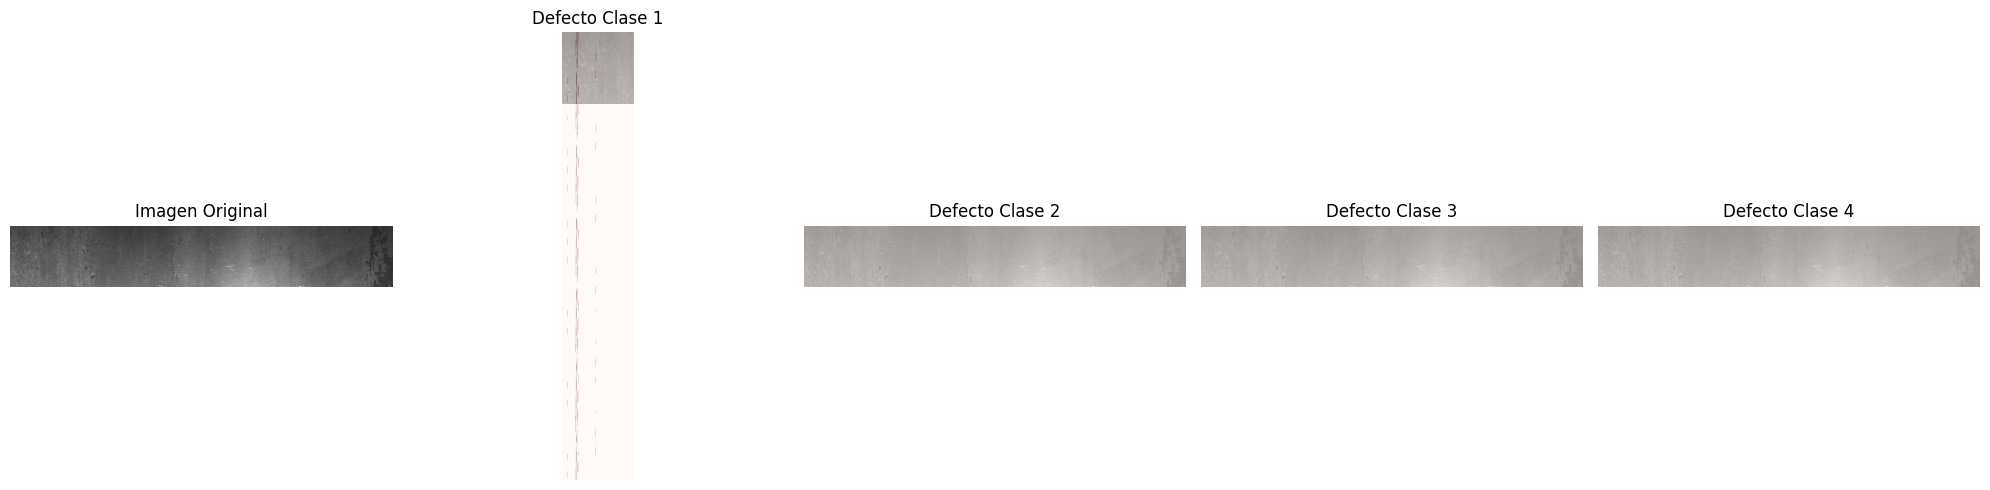

In [24]:
ejemplo_img = image_ids[0]
show_image_with_masks(ejemplo_img)

**Extracción de Características**

In [25]:
# Detectar Features con ORB
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Inicializamos ORB
orb = cv2.ORB_create(nfeatures=500)

def extract_orb_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    keypoints, descriptors = orb.detectAndCompute(image, None)
    return keypoints, descriptors

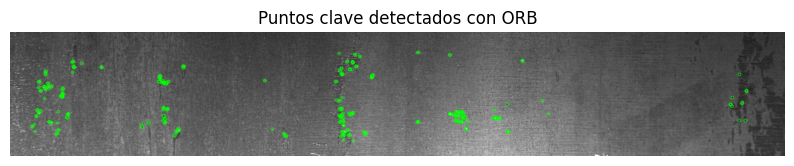

In [26]:
# Visualización de Keypoints
def show_orb_keypoints(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    keypoints, _ = orb.detectAndCompute(image, None)
    image_with_kp = cv2.drawKeypoints(image, keypoints, None, color=(0,255,0), flags=0)

    plt.figure(figsize=(10, 5))
    plt.imshow(image_with_kp, cmap='gray')
    plt.title('Puntos clave detectados con ORB')
    plt.axis('off')
    plt.show()

# Prueba con una imagen
show_orb_keypoints(os.path.join(TRAIN_IMAGES_DIR, ejemplo_img))

**Construcción de BoVW y Entrenar Clasificador**

In [27]:
# Extracción de descriptores de múltiples imágenes
from tqdm import tqdm

def get_all_orb_descriptors(image_ids, image_folder):
    descriptors_list = []
    valid_ids = []

    for img_id in tqdm(image_ids):
        path = os.path.join(image_folder, img_id)
        _, descriptors = extract_orb_features(path)
        if descriptors is not None:
            descriptors_list.append(descriptors)
            valid_ids.append(img_id)  # Solo guardamos las válidas

    return descriptors_list, valid_ids

In [28]:
# Agrupamiento de descriptores con KMeans (visual words)
from sklearn.cluster import MiniBatchKMeans

def build_codebook(descriptor_list, n_clusters=100):
    all_descriptors = np.vstack(descriptor_list)
    print("Total descriptores:", all_descriptors.shape)

    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=10000)
    kmeans.fit(all_descriptors)
    return kmeans

In [29]:
# Vectorización de cada imagen (histograma de palabras visuales)
def compute_bovw_features(descriptor_list, kmeans, n_clusters):
    features = []

    for descriptors in descriptor_list:
        if descriptors is None:
            hist = np.zeros(n_clusters)
        else:
            cluster_indices = kmeans.predict(descriptors)
            hist, _ = np.histogram(cluster_indices, bins=np.arange(n_clusters+1))
            hist = hist / np.linalg.norm(hist)  # Normalización
        features.append(hist)

    return np.array(features)

In [30]:
# Preparación de etiquetas de clase (defecto presente o no)
def get_labels(df, image_ids, class_id=1):
    labels = []

    for img_id in image_ids:
        match = df[(df['ImageId'] == img_id) & (df['ClassId'] == class_id)]

        # Validación de existencia
        if not match.empty and match['EncodedPixels'].notnull().values[0]:
            labels.append(1)  # Tiene defecto
        else:
            labels.append(0)  # No tiene defecto o no está registrada

    return np.array(labels)

100%|██████████| 500/500 [00:07<00:00, 68.86it/s]


Total descriptores: (117472, 32)
Tamaño de features: (291, 100)
Tamaño de labels: (291,)
Después de SMOTE:
Features: (912, 100)
Distribución de clases:
2    228
0    228
3    228
1    228
Name: count, dtype: int64
Matriz de confusión:
[[47  0  0  0]
 [ 0 52  1  0]
 [ 1  1 43  0]
 [ 0  0  3 35]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        47
           1       0.98      0.98      0.98        53
           2       0.91      0.96      0.93        45
           3       1.00      0.92      0.96        38

    accuracy                           0.97       183
   macro avg       0.97      0.96      0.97       183
weighted avg       0.97      0.97      0.97       183



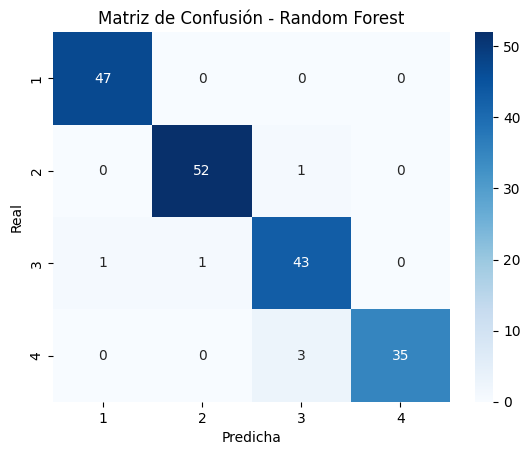

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import seaborn as sns

# Paso 0: Función auxiliar para obtener etiquetas multiclase
def get_labels_multiclass(df, valid_ids):
    df_valid = df[df['ImageId'].isin(valid_ids)]

    labels_dict = df_valid.groupby('ImageId')['ClassId'].first().astype(int) - 1

    # Filtrar IDs que sí tienen clase
    final_ids = [img_id for img_id in valid_ids if img_id in labels_dict]
    labels = [labels_dict[img_id] for img_id in final_ids]

    return np.array(labels), final_ids

# Muestreo aleatorio
sampled_ids = image_ids.sample(500, random_state=42)

# Obtener descriptores e IDs válidos
descriptor_list, valid_ids = get_all_orb_descriptors(sampled_ids, TRAIN_IMAGES_DIR)

# Crear codebook y vectorizar
n_clusters = 100
kmeans = build_codebook(descriptor_list, n_clusters)
features = compute_bovw_features(descriptor_list, kmeans, n_clusters)

# Obtener etiquetas multiclase
labels, valid_ids_filtered = get_labels_multiclass(df, valid_ids)

# Filtrar features para mantener solo los correspondientes a imágenes etiquetadas
filtered_indices = [i for i, img_id in enumerate(valid_ids) if img_id in valid_ids_filtered]
features = features[filtered_indices]

# Confirmar tamaños
print("Tamaño de features:", features.shape)
print("Tamaño de labels:", labels.shape)

# Paso 5: Balancear clases con SMOTE multiclase
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(features, labels)

print("Después de SMOTE:")
print("Features:", X_resampled.shape)
print("Distribución de clases:")
print(pd.Series(y_resampled).value_counts())

# Paso 6: Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Paso 7: Entrenar modelo
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

# Paso 8: Evaluación
y_pred = rf.predict(X_test)
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1,2,3,4], yticklabels=[1,2,3,4])
plt.xlabel('Predicha')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Random Forest')
plt.show()

**Mejora Visual de Imágenes**

In [32]:
# Preprocesamiento
def enhance_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Equalización de histograma
    image_eq = cv2.equalizeHist(image)

    # Filtro Gaussiano
    image_blur = cv2.GaussianBlur(image_eq, (5, 5), 0)

    # Detección de bordes (Canny)
    edges = cv2.Canny(image_blur, 100, 200)

    # Umbral adaptativo con Otsu
    _, thresh_otsu = cv2.threshold(image_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return {
        'original': image,
        'equalized': image_eq,
        'blurred': image_blur,
        'edges': edges,
        'otsu': thresh_otsu
    }

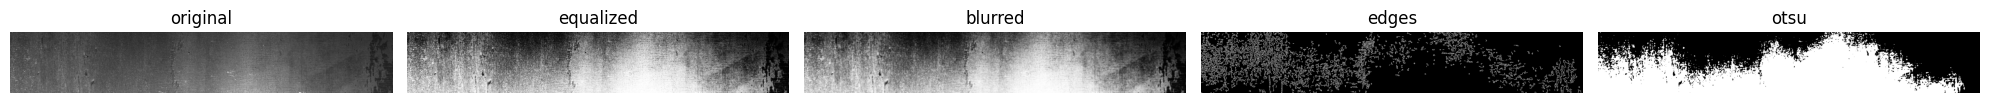

In [33]:
# Visualización Comparativa
def show_enhanced_versions(image_path):
    images = enhance_image(image_path)

    titles = list(images.keys())
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))

    for i, key in enumerate(titles):
        axs[i].imshow(images[key], cmap='gray')
        axs[i].set_title(key)
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Probar con una imagen
show_enhanced_versions(os.path.join(TRAIN_IMAGES_DIR, '0002cc93b.jpg'))

**Construcción de la Pipeline Final y Exportación**

In [34]:
# Clase personalizada para pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import cv2
import numpy as np
from tqdm import tqdm

class ORBBoVWTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, kmeans_model=None, n_clusters=100):
        self.kmeans_model = kmeans_model
        self.n_clusters = n_clusters

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        orb = cv2.ORB_create()
        features = []
        for path in tqdm(X, desc="Extrayendo BoVW"):
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                features.append(np.zeros(self.n_clusters))
                continue

            keypoints, descriptors = orb.detectAndCompute(img, None)
            if descriptors is None or len(descriptors) == 0:
                features.append(np.zeros(self.n_clusters))
                continue

            try:
                words = self.kmeans_model.predict(descriptors)
                hist, _ = np.histogram(words, bins=np.arange(self.n_clusters + 1))
                features.append(hist)
            except:
                features.append(np.zeros(self.n_clusters))

        return np.array(features)

In [35]:
def get_labels_multiclass(df, valid_ids):
    df_valid = df[df['ImageId'].isin(valid_ids)]
    labels_dict = df_valid.groupby('ImageId')['ClassId'].first().astype(int) - 1
    final_ids = [img_id for img_id in valid_ids if img_id in labels_dict]
    labels = [labels_dict[img_id] for img_id in final_ids]
    return np.array(labels), final_ids

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import joblib
import os

# Paso 1: Muestreo aleatorio de imágenes
sampled_ids = image_ids.sample(500, random_state=42)

# Paso 2: Obtener descriptores ORB y filtrar IDs válidos
descriptor_list, valid_ids = get_all_orb_descriptors(sampled_ids, TRAIN_IMAGES_DIR)

# Paso 3: Crear el codebook con KMeans
n_clusters = 100
kmeans_model = build_codebook(descriptor_list, n_clusters=n_clusters)

# Paso 4: Obtener etiquetas multiclase
labels, valid_ids_filtered = get_labels_multiclass(df, valid_ids)

# Paso 5: Filtrar las rutas válidas (solo imágenes con etiquetas)
image_ids_with_labels = [img_id for img_id in valid_ids if img_id in valid_ids_filtered]
image_paths = [os.path.join(TRAIN_IMAGES_DIR, img_id) for img_id in image_ids_with_labels]

# Paso 6: Construir el pipeline
pipeline = Pipeline([
    ('bovw', ORBBoVWTransformer(kmeans_model=kmeans_model, n_clusters=n_clusters)),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

# Paso 7: Entrenar el pipeline
pipeline.fit(image_paths, labels)

# Paso 8: Guardar el pipeline y el codebook (si querés usarlo después)
joblib.dump(pipeline, 'steel_defect_multiclass_pipeline.pkl')
joblib.dump(kmeans_model, 'orb_kmeans_model.pkl')

print("Pipeline multiclase guardada exitosamente.")

100%|██████████| 500/500 [00:05<00:00, 87.45it/s]


Total descriptores: (117472, 32)


Extrayendo BoVW: 100%|██████████| 291/291 [00:07<00:00, 40.39it/s]


Pipeline multiclase guardada exitosamente.


**Cargar la pipeline y predecir sobre una imagen nueva**

In [37]:
import joblib
import cv2
import os

# Cargar el pipeline previamente guardado
pipeline = joblib.load('steel_defect_multiclass_pipeline.pkl')

# Carpeta con las nuevas imágenes a clasificar
carpeta_imagenes = '/content/drive/MyDrive/Vision_computadora/Taller_2/test_images'  # Cambiá esto

# Obtener todas las rutas a imágenes en la carpeta
extensiones_validas = ('.jpg', '.jpeg', '.png', '.bmp')
imagenes = [os.path.join(carpeta_imagenes, f)
            for f in os.listdir(carpeta_imagenes)
            if f.lower().endswith(extensiones_validas)]

# Verificar si hay imágenes
if not imagenes:
    print("No se encontraron imágenes en la carpeta.")
else:
    # Realizar predicciones
    predicciones = pipeline.predict(imagenes)

    # Mostrar resultados
    for ruta, pred in zip(imagenes, predicciones):
        nombre = os.path.basename(ruta)
        print(f"{nombre} => Clase {pred + 1}")

# Guardar en CSV

import pandas as pd

df_resultados = pd.DataFrame({
    'imagen': [os.path.basename(p) for p in imagenes],
    'clase_predicha': [int(p) + 1 for p in predicciones]
})

df_resultados.to_csv('predicciones_resultado.csv', index=False)
print("Predicciones guardadas en predicciones_resultado.csv")


Extrayendo BoVW: 100%|██████████| 5505/5505 [03:15<00:00, 28.13it/s]


d1d054d6f.jpg => Clase 3
d1dbcdd73.jpg => Clase 3
d1d1e5ce4.jpg => Clase 3
d1b14f8de.jpg => Clase 3
d1ae5708a.jpg => Clase 3
d1010eb14.jpg => Clase 3
d0f83a37f.jpg => Clase 3
d20453181.jpg => Clase 3
d19f4f267.jpg => Clase 3
d118e5d28.jpg => Clase 3
d1ffe3bb4.jpg => Clase 3
d1094a21e.jpg => Clase 3
d22364fb6.jpg => Clase 3
d0e50871e.jpg => Clase 3
d2033d01e.jpg => Clase 3
d1b3aa6e7.jpg => Clase 3
d1af014c5.jpg => Clase 3
d18e48954.jpg => Clase 3
d1a765848.jpg => Clase 3
d10aa3eaa.jpg => Clase 3
d22160e16.jpg => Clase 3
d221d2a3f.jpg => Clase 3
d181eaa7a.jpg => Clase 3
d2d0ce0d2.jpg => Clase 3
d37025202.jpg => Clase 3
d29833610.jpg => Clase 3
d328fa7ca.jpg => Clase 3
d249e6983.jpg => Clase 3
d30c49bd3.jpg => Clase 3
d3122844c.jpg => Clase 3
d33dfa024.jpg => Clase 3
d3764cee5.jpg => Clase 3
d23579fb1.jpg => Clase 3
d387d301f.jpg => Clase 3
d25120582.jpg => Clase 3
d3797515c.jpg => Clase 3
d3801de15.jpg => Clase 3
d3705608b.jpg => Clase 3
d2482b60f.jpg => Clase 3
d28f267cd.jpg => Clase 3


**Añadir optimización de hiperparámetros con GridSearchCV**

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Definir pipeline de nuevo
pipeline = Pipeline([
    ('bovw', ORBBoVWTransformer(kmeans_model=kmeans_model, n_clusters=n_clusters)),
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Parámetros a probar
param_grid = {
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [None, 10, 20]
}

# GridSearch
grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_macro')
grid.fit(image_paths, labels)

# Resultados
print("Mejores hiperparámetros:", grid.best_params_)

# Guardar mejor modelo
joblib.dump(grid.best_estimator_, 'steel_defect_pipeline_opt.pkl')


Extrayendo BoVW: 100%|██████████| 291/291 [00:08<00:00, 36.35it/s]


Mejores hiperparámetros: {'clf__max_depth': None, 'clf__n_estimators': 50}


['steel_defect_pipeline_opt.pkl']